## LangGraph, capture user's input
This script is to capture the user's input and display it. This will demonstrate the Human-In-Loop (HIL) feature of LangGraph.

In [1]:
# Load environments
from dotenv import load_dotenv
import os
import os.path

def load_env_file(filepath):
    with open(filepath) as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value

# Load the environment variables
filename = ".env.local"
full_path = os.path.join(os.getcwd(), filename)
print(full_path)

if os.path.exists(full_path): 
    load_env_file(full_path)     
else:
    load_dotenv()

c:\Repository\LangGraph\LangGraph-101\.env.local


In [2]:
from typing import TypedDict,List
from langchain.schema import BaseMessage

# Define our state structure
class State(TypedDict):
    messages: List[BaseMessage]
    next_step: str

In [7]:
from langgraph.graph import StateGraph, END
from groq import Groq

# StateGraph
workflow = StateGraph(State)

# Node to ask the question
def ask_human(state: State) -> State:
    state["messages"].append({"role": "assistant", "content": "Hello! What's your query?"})
    state["next_step"] = "query_llm"

    return state

def query_llm(state:State) -> State:
    query = state["messages"][-1]["content"]
    client  = Groq(api_key = os.getenv("GROQ_API_KEY"))
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": query
            }
        ],
        model="gemma2-9b-it",
        stream=False
    )

    state["messages"].append({"role": "assistant", "content": chat_completion.choices[0].message.content})
    state["next_step"] = "end"
    return state

# Add nodes to workflow
workflow.add_node("ask_human", ask_human)
workflow.add_node("query_llm", query_llm)

# Lets wireup the node with start and end nodes
workflow.set_entry_point("ask_human")  # Pointing the _START_ node
workflow.add_edge("ask_human", "query_llm") 
workflow.add_edge("query_llm", END)  # Pointing the _END_ node

# All done, lets compile the workflow to make an app
graph = workflow.compile()

Now the workflow is compiled and ready for execution. We can visualize the workflow that we created to identify any mistages.

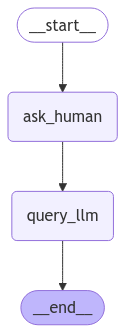

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Run the app/workflow

In [9]:
import uuid

init_state = {"next_step":"", "messages":[]}
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

for event in graph.stream(init_state, config):
    for output in event.values():
        if "messages" in output:
            for message in output["messages"]:
                if message["role"] == "assistant":
                    print(f"Assistant: {message['content']}")
                elif message["role"] == "human":
                    print(f"Human: {message['content']}")
    
    # Check if 'next_step' exists
    if "next_step" in output and output["next_step"] == "query_llm":
        user_input = input("Your response: ")
        output["messages"].append({"role": "human", "content": user_input})
                    
print("End of workflow")

Assistant: Hello! What's your query?
Assistant: Hello! What's your query?
Human: what is your name
Assistant: My name is Gemma. I am an open-weights AI assistant.

End of workflow
